In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

# Test EM with sparsity

In this part we generate a fake classifier that gets oracle results but outputs a 1000 sparsity signal. We will use it with the algorithm to check that our code works correctly.

In [2]:
dataset_path="/home/jkipen/raid_storage/ProtInfGPU/data/20642_Prot/binary/";
classifier_name="SparsityTest";

In [3]:
#Some functions to simplify 
def create_folder(folder_path):
    if not os.path.exists(folder_path):  
        os.makedirs(folder_path)
def create_classifier_folders(ds_path,classifier_name):
    classifier_path=ds_path+"/"+classifier_name;
    create_folder(classifier_path);
    create_folder(classifier_path+"/CrossVal"); #Create subfolders
    create_folder(classifier_path+"/Common");
def copy_all_files(src_folder, dst_folder):
    """Copies all files from src_folder to dst_folder, creating dst_folder if it doesn't exist."""
    #os.makedirs(dst_folder, exist_ok=True)  # Ensure the destination folder exists
    for file_name in os.listdir(src_folder):
        src_file = os.path.join(src_folder, file_name)
        dst_file = os.path.join(dst_folder, file_name)
        if os.path.isfile(src_file):  # Ensure it's a file before copying
            shutil.copy2(src_file, dst_file)
def copy_oracle_info_to_classifier(ds_path,classifier_name):
    #copy_all_files(os.path.join(ds_path, "Oracle", "Common"),
    #               os.path.join(ds_path, classifier_name, "Common"))
    copy_all_files(os.path.join(ds_path, "Oracle", "CrossVal"),
                   os.path.join(ds_path, classifier_name, "Crossval"));
    

In [13]:
create_classifier_folders(dataset_path,classifier_name);
copy_oracle_info_to_classifier(dataset_path,classifier_name);

In [6]:
trueIds=np.fromfile(dataset_path+"Common/trueIds.bin",dtype=np.uint32)
trueIds

array([     0,      0,      0, ..., 152290, 152290, 152290], dtype=uint32)

In [7]:
nSparsity=10;
TopNScoresAux=np.zeros((len(trueIds),nSparsity),dtype=np.float32);
TopNScoresIdAux=np.zeros((len(trueIds),nSparsity),dtype=np.uint32);

In [8]:
TopNScoresIdAux[:,0]=trueIds; #These top scores dont have other idxs for sparsity values and are not ordered
TopNScoresAux[:,0]=1;
auxMat=np.tile(np.arange(nSparsity), (len(trueIds), 1));
TopNScoresIdAux= (trueIds.reshape(-1, 1)+auxMat)%(np.max(trueIds)+1) # here we create
sort_indices = np.argsort(TopNScoresIdAux, axis=1)
rows = np.arange(TopNScoresIdAux.shape[0])[:, None]  # Row indices for broadcasting
TopNScoresAux[:] = TopNScoresAux[rows, sort_indices]
TopNScoresIdAux[:] = TopNScoresIdAux[rows, sort_indices]

In [13]:
TopNScoresAuxF=TopNScoresAux.flatten();
TopNScoresIdAuxF=TopNScoresIdAux.flatten();

In [24]:
TopNScoresAuxF.astype(np.float32).tofile(dataset_path+classifier_name+"/Common/TopNScores.bin")
TopNScoresIdAuxF.astype(np.uint32).tofile(dataset_path+classifier_name+"/Common/TopNScoresId.bin")

In [49]:
nSpar=np.array([10],dtype=np.uint32 )
nSpar.tofile(dataset_path+classifier_name+"/Common/nSparsity.bin")

In [28]:
TopNScoresIdAuxF[-20:]
#TopNScoresIdAux[152289000,:]

array([     0,      1,      2,      3,      4,      5,      6,      7,
            8, 152290,      0,      1,      2,      3,      4,      5,
            6,      7,      8, 152290])

In [26]:
aux=np.fromfile(dataset_path+classifier_name+"/Common/TopNScoresId.bin",dtype=np.uint32)

In [29]:
aux[-20:]

array([     0,      1,      2,      3,      4,      5,      6,      7,
            8, 152290,      0,      1,      2,      3,      4,      5,
            6,      7,      8, 152290], dtype=uint32)

In [9]:
TopNScoresIdAux

array([[     0,      1,      2, ...,      7,      8,      9],
       [     0,      1,      2, ...,      7,      8,      9],
       [     0,      1,      2, ...,      7,      8,      9],
       ...,
       [     0,      1,      2, ...,      7,      8, 152290],
       [     0,      1,      2, ...,      7,      8, 152290],
       [     0,      1,      2, ...,      7,      8, 152290]])

# Generating Whatprot format datasets

In [2]:
whatprot_path= "/../ext/whatprot/cc_code/bin/release/whatprot"
common_path_datasets= "/raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/"
dye_seqs_path=common_path_datasets + "dye-seqs.tsv"
params_path = common_path_datasets + "seqparams_atto647n_x3.json"
n_samples_per_dataset=10000000; #5 Gb per dataset

In [38]:
n_datasets=10;
for i in range(n_datasets):
    rad_path = common_path_datasets+ "MultiDatasets/radiometries_"+str(i)+".tsv";
    true_ids_path = common_path_datasets+ "MultiDatasets/true-ids_"+str(i)+".tsv";
    command = "." +whatprot_path + " simulate rad -t 40 -g "+str(n_samples_per_dataset) +" -P "+ params_path+" -S "+dye_seqs_path+" -R "+rad_path+" -Y "+true_ids_path;
    print(command)
    os.system(command)

./../ext/whatprot/cc_code/bin/release/whatprot simulate rad -t 40 -g 10000000 -P /raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/seqparams_atto647n_x3.json -S /raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/dye-seqs.tsv -R /raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/MultiDatasets/radiometries_0.tsv -Y /raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/MultiDatasets/true-ids_0.tsv
Finished basic setup (0.000636078 seconds).
Read 152291 dye seqs (0.109483 seconds).
Finished generating 9994767 radiometries (217.689seconds).
Finished saving results (1345.08 seconds).
Total run time: 1562.88 seconds.
./../ext/whatprot/cc_code/bin/release/whatprot simulate rad -t 40 -g 10000000 -P /raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/seqparams_atto647n_x3.json -S /raid/jkipen/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlock

In [39]:
all_true_ids=[]
for i in range(10):
    df = pd.read_csv(common_path_datasets+ "MultiDatasets/true-ids_"+str(i)+".tsv", sep="\t");
    all_true_ids.append(df.to_numpy().flatten());

In [40]:
all_true_ids=np.concatenate(all_true_ids)
u,counts=np.unique(all_true_ids,return_counts=True)
print(np.max(counts))
print(np.min(counts))
print(len(u))

1294
209
152291


This means that with these datasets we can create an extra dataset with samples up to 390 of each dye seq!. Now lets get those datasets together and pick 100 of them!


In [42]:
dfs = [] #Vibe coding (This one uses a lot of memory, so for big datasets I will do another
for i in range(10):
    dfr = pd.read_csv(common_path_datasets+ "MultiDatasets/radiometries_"+str(i)+".tsv", sep="\t", header=None, skiprows=3); #Skipping metadata rows
    dft = pd.read_csv(common_path_datasets+ "MultiDatasets/true-ids_"+str(i)+".tsv", sep="\t", header=None, skiprows=1); #Skipping metadata rows
    dfr['true_ids'] = dft[0]
    dfs.append(dfr)
    
big_df = pd.concat(dfs, axis=0, ignore_index=True)
result_df = big_df.groupby('true_ids', group_keys=False).apply(lambda group: group.head(100))

MemoryError: Unable to allocate 89.4 GiB for an array with shape (120, 99949335) and data type float64

In [ ]:
for i in range(10):
    dfr = pd.read_csv(common_path_datasets+ "MultiDatasets/radiometries_"+str(i)+".tsv", sep="\t", header=None, skiprows=3); #Skipping metadata rows
    dft = pd.read_csv(common_path_datasets+ "MultiDatasets/true-ids_"+str(i)+".tsv", sep="\t", header=None, skiprows=1); #Skipping metadata rows
    dfr['true_ids'] = dft[0]
    if i==0:
        dfs = dfr.groupby('true_ids', group_keys=False).apply(lambda group: group.head(100))
    else:
        dfs = pd.concat([dfs, dfr], axis=0, ignore_index=True)
        dfs = dfs.groupby('true_ids', group_keys=False).apply(lambda group: group.head(100))
result_df=dfs

In [ ]:
result_df.to_csv(common_path_datasets+"aux.csv", index=False)

In [ ]:
# Parameters for the header of the output file
#Vibe oding
radiometries_df = result_df.drop(columns=['true_ids'])
true_ids_series = result_df['true_ids']

# Get the number of reads (rows) from the filtered data
num_reads = len(result_df)

# Save the final radiometries file with custom header
num_timesteps = 40   # Given constant: number of timesteps
num_channels = 3     # Given constant: number of channels



# Save the final true IDs file with custom header (only number of reads)
true_ids_output_file = common_path_datasets+"true-ids.tsv"
with open(true_ids_output_file, "w") as f:
    f.write(f"{num_reads}\n")
    true_ids_series.to_csv(f, sep="\t", index=False, header=False)


In [ ]:
radiometries_output_file = common_path_datasets+"radiometries.tsv"
with open(radiometries_output_file, "w") as f:
    f.write(f"{num_timesteps}\n")
    f.write(f"{num_channels}\n")
    f.write(f"{num_reads}\n")
    radiometries_df.to_csv(f, sep="\t", index=False, header=False)

In [ ]:
# Creating normal whatprot clas

### Reduced dataset
This dataset resulted way too big to analyze before getting results, we try making a reduced version:

In [ ]:
df_big=pd.read_csv(common_path_datasets+"aux.csv")
df_small = df_big.groupby('true_ids', group_keys=False).apply(lambda group: group.head(2))
#df_small.drop(df_small.columns[0], axis=1) #There was the index column, lets remove it!
df_small.to_csv(common_path_datasets+"Reduced/aux.csv",index=False)
#df_small=pd.read_csv(common_path_datasets+"Reduced/aux.csv")

In [ ]:
common_path_datasets_reduced=common_path_datasets+"Reduced/";
radiometries_df = df_small.drop(columns=['true_ids'])
true_ids_series = df_small['true_ids']

# Get the number of reads (rows) from the filtered data
num_reads = len(df_small)

# Save the final radiometries file with custom header
num_timesteps = 40   # Given constant: number of timesteps
num_channels = 3     # Given constant: number of channels



# Save the final true IDs file with custom header (only number of reads)
true_ids_output_file = common_path_datasets_reduced+"true-ids.tsv"
with open(true_ids_output_file, "w") as f:
    f.write(f"{num_reads}\n")
    true_ids_series.to_csv(f, sep="\t", index=False, header=False)
    
radiometries_output_file = common_path_datasets_reduced+"radiometries.tsv"
with open(radiometries_output_file, "w") as f:
    f.write(f"{num_timesteps}\n")
    f.write(f"{num_channels}\n")
    f.write(f"{num_reads}\n")
    radiometries_df.to_csv(f, sep="\t", index=False, header=False)

## Analyzing probeam results

Now after generated the dataset, I got the scores when running probeam on it. These results are gonna be analyzed here before running them on the CUDA code of EM:

In [2]:
def loadScores(folder,n_rows=-1,n_sparsity=1000):
    if n_rows== (-1):
        allScores=np.fromfile(folder+"TopNScores.bin", dtype=np.float32)
        allScoresId=np.fromfile(folder+"TopNScoresId.bin", dtype=np.uint32)
    else:
        allScores=np.fromfile(folder+"TopNScores.bin", dtype=np.float32,count =n_rows*n_sparsity)
        allScoresId=np.fromfile(folder+"TopNScoresId.bin", dtype=np.uint32,count =n_rows*n_sparsity)
    allScores=allScores.reshape(-1, n_sparsity)
    allScoresId=allScoresId.reshape(-1, n_sparsity)
    return allScores,allScoresId

def sanity_check(allScores,allScoresId):
    print("Max prob: " + str(np.max(allScores)))
    print("Max id: " + str(np.max(allScoresId)))
    print("Count of decreasing or same idx in rows: " + str(np.sum(np.diff(allScoresId,axis=1)<=0)))
    
def accuracy(allScores,allScoresId,true_labels):
    max_indices = np.argmax(allScores, axis=1) 
    top_ids = allScoresId[np.arange(allScores.shape[0]), max_indices]
    accuracy = np.mean(top_ids == true_labels)
    print("The obtained accuracy was: "+str(accuracy))

def plot_acc_accuracy(allScores):
    allScoresSorted=np.sort(allScores,axis=1)[:, ::-1]
    allScoresSortedCumsum=np.cumsum(allScoresSorted,axis=1)
    mean_acc=np.mean(allScoresSortedCumsum,axis=0)
    plt.plot(1-mean_acc)
    plt.ylabel("Residual probability")
    plt.xlabel("N sparsity")
    plt.grid()
    plt.show()
    print("The final residual probability is " + str(1-mean_acc[-1]))

def analyze_whatprot_results(path_results,true_labels):
    df=pd.read_csv(path_results)
    est_labels=df["best_pep_iz"].to_numpy()
    accuracy = np.mean(est_labels == true_labels)
    print("The obtained whatprot accuracy was: "+str(accuracy))
    

Max prob: 1.0000001
Max id: 152290
Count of decreasing or same idx in rows: 0
The obtained accuracy was: 0.9503450630700435


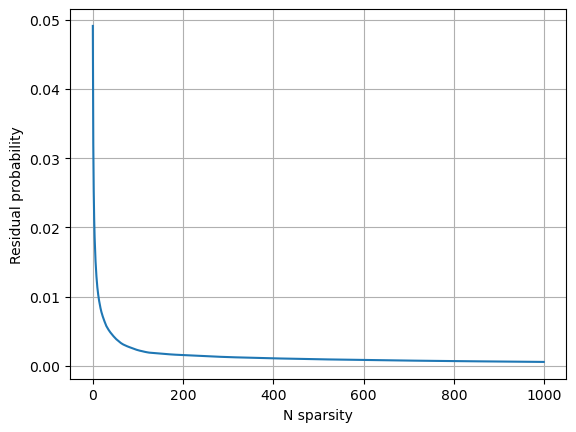

The final residual probability is 0.0005434751510620117


In [3]:
n_sparsity=1000;
folder_path="/home/jkipen/raid_storage/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/Reduced/"

allScores,allScoresId=loadScores(folder_path)
sanity_check(allScores,allScoresId)
true_labels=np.repeat(np.arange(len(allScores)/2), 2).astype(int)
accuracy(allScores,allScoresId,true_labels)
plot_acc_accuracy(allScores)

Max prob: 1.0000002
Max id: 152290
Count of decreasing or same idx in rows: 0
The obtained accuracy was: 1.3132752427917604e-07


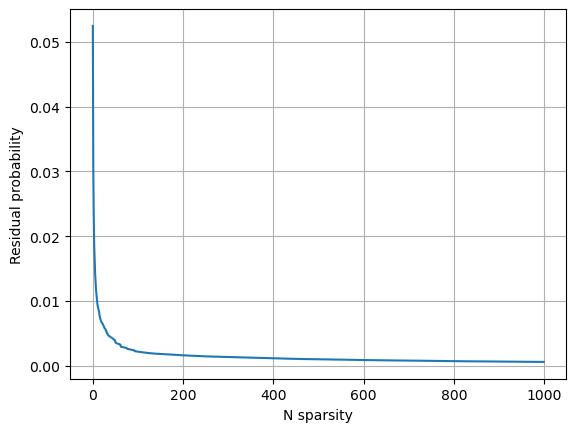

The final residual probability is 0.0005851387977600098


In [6]:
n_sparsity=1000; ##Is there difference between the reduced set or not?
folder_path="/home/jkipen/raid_storage/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/"

allScores,allScoresId=loadScores(folder_path)
sanity_check(allScores,allScoresId)
true_labels=np.repeat(np.arange(len(allScores)/2), 2).astype(int)
accuracy(allScores,allScoresId,true_labels)
plot_acc_accuracy(allScores)

The obtained accuracy was: 0.9504406038439567


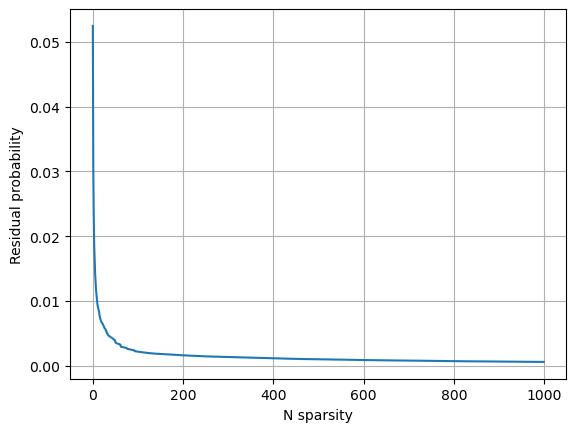

The final residual probability is 0.0005851387977600098


In [7]:
true_labels=np.repeat(np.arange(len(allScores)/100), 100).astype(int)
accuracy(allScores,allScoresId,true_labels)
plot_acc_accuracy(allScores)

Max prob: 1.0000005
Max id: 152290
Count of decreasing or same idx in rows: 0
The obtained accuracy was: 0.056690809043213324


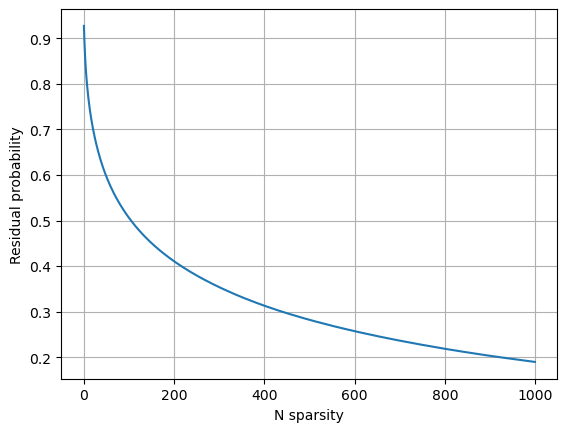

The final residual probability is 0.18962198495864868


In [6]:
n_sparsity=1000;
folder_path="/home/jkipen/raid_storage/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/ProbeamPaperParams/Reduced/"

allScores,allScoresId=loadScores(folder_path)
sanity_check(allScores,allScoresId)
true_labels=np.repeat(np.arange(len(allScores)/2), 2).astype(int)
accuracy(allScores,allScoresId,true_labels)
plot_acc_accuracy(allScores)

In [16]:
whatprot_res="/home/jkipen/raid_storage/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/ProbeamPaperParams/Reduced/predictions.csv"
true_labels=np.repeat(np.arange(len(allScores)/2), 2).astype(int)
analyze_whatprot_results(whatprot_res,true_labels)

The obtained whatprot accuracy was: 0.056605446152431856


In [4]:
whatprot_res="/home/jkipen/raid_storage/ProtInfGPU/data/WhatprotGen/WholeProteomeTests/NoBlockageBetterRates/Reduced/predictions.csv"
true_labels=np.repeat(np.arange(len(allScores)/2), 2).astype(int)
analyze_whatprot_results(whatprot_res,true_labels)

The obtained whatprot accuracy was: 0.9499740628139549


## Accuracy seems to stuck in a certain porectange

It seems that even reducing a lot the errors still gets an accuracy of 38%, which still does not work very well to correct the errors. After manually inspecting, it seems that there is a lot of dye sequences that are very long, so only 10 cycles are not good enough to differentiate them!

I want to plot how many dye-seqs would have the same pattern when error free if only N cycles of edman were done!



In [2]:
df=pd.read_csv("/home/jkipen/raid_storage/ProtInfGPU/data/20642_Prot/binary/ProbeamBetterConfig/ExpTable.csv")
df_filtered = df.drop_duplicates(subset="Flustring Id", keep="first")[["Flustring Id", "Flustring"]];
n_flus=len(df_filtered);
flustrings_rev=df_filtered["Flustring"].to_list()
flustrings=[seq[::-1] for seq in flustrings_rev]

For each number of edman degradations, we will see the ideal output we should observe. Then we will compute the maximum accuracy we could have. This for many different edman cycle numbers

In [31]:
def dye_seq_to_dye_track(dye_seq,n_ed_cycles):
    dye_track=np.zeros((n_ed_cycles+1,n_colors))
    dye_track[0,:]=[dye_seq.count('0'),dye_seq.count('1'),dye_seq.count('2')]
    for idx,char in enumerate(dye_seq):
        if idx>=n_ed_cycles:
            break
        else:
            dye_track[idx+1,:]=dye_track[idx,:]
            if char.isdigit():
                #print(char)
                dye_track[idx+1,int(char)]=dye_track[idx+1,int(char)]-1
    return dye_track

In [34]:
n_ed_cycles_test=[9, 12, 15, 18, 20, 25, 30, 35, 40];
max_accs=[]

for n_ed_cycles in n_ed_cycles_test:
    n_colors=3;
    dye_tracks=np.zeros((n_flus,n_ed_cycles+1,n_colors))
    for n,dye_seq in enumerate(flustrings):
        dye_tracks[n,:,:]=dye_seq_to_dye_track(dye_seq,n_ed_cycles);

    flattened =[tuple(dye_tracks[i].flatten()) for i in range(dye_tracks.shape[0])] 
    unique_patterns, counts = np.unique(flattened, return_counts=True, axis=0) #The ones that have the same pattern will be guessed 1/n_count of the same time rights
    max_accs.append(len(unique_patterns)/n_flus) #If we sum the probability of each, we get that the ideal classifier in this case will sum len(unique_patterns).


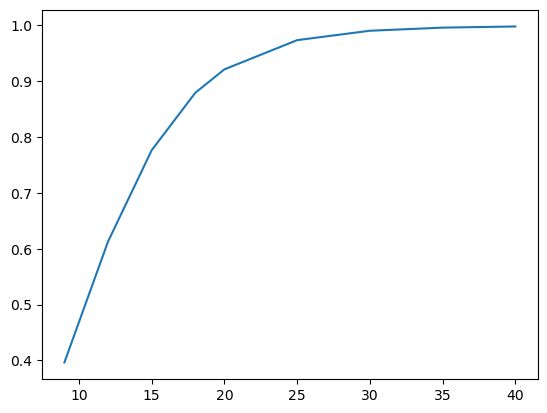

In [35]:
plt.plot(n_ed_cycles_test,max_accs)

In [36]:
print(max_accs)
print(n_ed_cycles_test)

[0.39634646827455333, 0.6128398920487751, 0.7763098278952795, 0.8792574741777255, 0.9211443880465687, 0.9734652737193925, 0.9902883295795549, 0.9958828821138478, 0.9979381578688169]
[9, 12, 15, 18, 20, 25, 30, 35, 40]
